In [5]:
import numpy as np
from Agents import *
from Environments import *
from Experiments import *
from Utils import *
from warnings import filterwarnings
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import pickle as cPickle

In [6]:
EXPERIMENT = 'epochs'
GRIDWORLD = 'WILLEMSEN'
AGENT_TYPE = 'ME_Q'
PLOT = True
ANIMATE = False
MAX_STEPS = 10000
EPISODE_TIMEOUT = 33
GAMMA = 0.9
ALPHA = 0.1
RSS_ALPHA = 0.1
LIN_ALPHA = 0.0001
BATCH_SIZE = 10
WEIGHTS_METHOD = 'exp_size_corrected'
EXPLOIT = True
EPSILON = 0.1
EPOCHS = 100

cwd = os.getcwd()
FOLDER = "%s\\Results" % (cwd)
FILE_SIG = f"{EXPERIMENT}_{AGENT_TYPE}_{GRIDWORLD}_n[{MAX_STEPS}]_alpha[{ALPHA}]_gamma[{GAMMA}]_batch[{BATCH_SIZE}]_weights[{WEIGHTS_METHOD}]_exploit[{EXPLOIT}]"
print(FILE_SIG)

epochs_ME_Q_WILLEMSEN_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True]


In [7]:
if GRIDWORLD == "WILLEMSEN":
    grid = np.ones((3, 9)) * -1
    grid[1, :8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0
    terminal_state = []
    for i in [0, 2]:
        for j in range(8):
            terminal_state.append([i, j])
    terminal_state.append([1, 8])
    # terminal_state.append([0, 8])
    # terminal_state.append([2, 8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8], [2, 8]])
elif GRIDWORLD == "STRAIGHT":
    grid = np.ones((3, 9)) * -1
    grid[1, :8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0.1
    terminal_state = []
    for i in [0]:
        for j in range(8):
            terminal_state.append([i, j])
    terminal_state.append([1, 8])
    # terminal_state.append([0, 8])
    # terminal_state.append([2, 8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8], [2, 8]])
elif GRIDWORLD == "POOL":
    grid = np.ones((8, 8)) * 0
    grid[3:6, 3:6] = -1
    grid[7, 7] = 1
    terminal_state = np.array([7, 7])
    initial_state = np.array([1, 0])
    blacked_state = np.array([[5, 5], [4, 5], [5, 4], [4, 4]])
    # blacked_state = np.array([[np.nan, np.nan], [np.nan, np.nan]])
elif GRIDWORLD == "STAR":
    grid = np.ones((15, 15)) * 0.1
    grid[7, 0] = -1
    grid[14, 7] = -1
    grid[7, 14] = 1
    grid[0, 7] = 1
    terminal_state = np.array([[7,0], [14,7], [7,14], [0,7]])
    initial_state = np.array([7,7])
    blacked_state = np.array([np.nan, np.nan])

env = Gridworld(grid, terminal_state, initial_state, blacked_state)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state)

if GRIDWORLD == "STRAIGHT" or GRIDWORLD=="WILLEMSEN":
    states = [(i, j) for i in [0, 1, 2] for j in range(env.grid_width)]
    env_shape = (3, env.grid_width)
elif GRIDWORLD == "POOL" or GRIDWORLD == "STAR":
    states = [(i, j) for i in range(env.grid_height) for j in range(env.grid_width)]
    env_shape = (env.grid_height, env.grid_width)
else:
    print("WORLD not found")

In [8]:
AGENTS = {
    "SIMPLE_Q": SimpleQ,
    "ME_Q": MEQ,
    "NOVELTOR": Noveltor,
    "RMAX": RMAXQ,
    }

agent = AGENTS[AGENT_TYPE]()
rb = ReplayMemory(max_size=10000)

In [13]:
# MAIN TRAINING and EVALUATION LOOP
M = []
for n in tqdm(range(EPOCHS)):
    agent = AGENTS[AGENT_TYPE]()
    rb = ReplayMemory(max_size=10000)
    env.reset()
    env_greedy.reset()
    metrics, trajectories = train_and_eval(MAX_STEPS, BATCH_SIZE, agent, rb, env, env_greedy, states, env_shape, EXPLOIT)
    M.append(metrics)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
# percentile based on
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

# adapted according to empirical on
# https://github.com/LizaLebedeva/bootstrap-experiments/blob/master/bootstrap_methods.ipynb

def bootstrap_empirical(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    obs_metric = func(data) # compute CI center from data directly
#     simulations = simulations - obs_metric # now move bootstrap to differences
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        percentile_upper = simulations[l_indx]
        percentile_lower = simulations[u_indx]
        empirical_lower = 2*obs_metric - percentile_lower
        empirical_upper = 2*obs_metric - percentile_upper
        return(empirical_lower,empirical_upper)
    return(ci)

In [10]:
R = np.zeros((EPOCHS, MAX_STEPS, 2))

for i, epoch in enumerate(M):
    for j, metrics in enumerate(epoch):
        for exp, g in enumerate(metrics['Gn']):
            R[i,j, 0] += GAMMA**exp*g
        for exp, g in enumerate(metrics['Gg']):
            R[i,j, 1] += GAMMA**exp*g

In [11]:
Rn = R[:,:,0]
Rg = R[:,:,1]
yn = np.mean(Rn, axis=0)
yg = np.mean(Rg, axis=0)
yCIn = list(map(lambda p: bootstrap_empirical(p)(0.95), Rn.T))
yCIg = list(map(lambda p: bootstrap_empirical(p)(0.95), Rg.T))
Yn = np.transpose(yCIn)
Yg = np.transpose(yCIg)

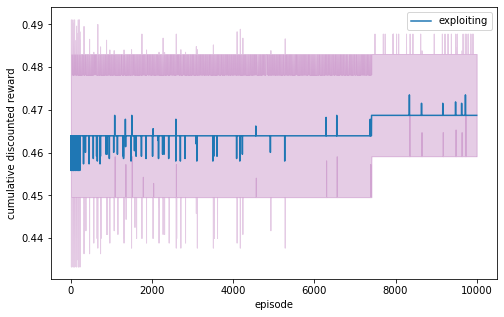

In [18]:
%matplotlib inline
x = np.arange(0, MAX_STEPS, 1)

fig, ax = plt.subplots(figsize=(8,5))
# plt.plot(x, yn, label='exploring')
# ax.fill_between(x, Yn[0], Yn[1], color='teal', alpha=.2)

plt.plot(x, yg, label='exploiting')
ax.fill_between(x, Yg[0], Yg[1], color='purple', alpha=.2)

plt.ylabel('cumulative discounted reward')
plt.xlabel('episode')

plt.legend()
plt.savefig(f'results/{FILE_SIG}_exploit.png')
plt.show()

In [18]:
with open('%s.txt'%FILE_SIG, 'wb') as fh:
    cPickle.dump(M, fh)

In [ ]:
# load me q willemsen
with open ('results/epochs_ME_Q_WILLEMSEN_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True].txt', 'rb') as fh:
    M = cPickle.load(fh)

In [3]:
# load simple q willemsen
with open ('results/epochs_SIMPLE_Q_WILLEMSEN_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True].txt', 'rb') as fh:
    M = cPickle.load(fh)

In [26]:
M[90][0].items()

dict_items([('t', 0), ('V', array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.4782969, 0.531441 , 0.59049  , 0.6561   , 0.729    , 0.81     ,
        0.9      , 1.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ]])), ('A', array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 3, 3, 3, 3, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)), ('S', (1, 8)), ('Gn', [1.0]), ('Gg', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]), ('W', array([1.])), ('K', [109]), ('RSS', array([0.05474769])), ('AIC', array([-26144860.74743245])), ('steps', 1)])